<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/giswqs/qgis-earthengine-examples/blob/master/Folium/ee-api-folium-setup.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/giswqs/qgis-earthengine-examples/tree/master/Folium/ee-api-folium-setup.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td><td>
<a target="_blank"  href="https://nbviewer.jupyter.org/github/giswqs/qgis-earthengine-examples/blob/master/Folium/ee-api-folium-setup.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td><td>
<a target="_blank"  href="https://mybinder.org/v2/gh/giswqs/qgis-earthengine-examples/master?filepath=Folium%2Fee-api-folium-setup.ipynb"><img width=58px src="https://mybinder.org/static/images/logo_social.png" />Run in binder</a></td></table>

# Earth Engine Python API and Folium Interactive Mapping

This notebook demonstrates how to setup the [Earth Engine Python API](https://developers.google.com/earth-engine/python_install) in the [Google Colaboratory](https://colab.sandbox.google.com/notebooks/welcome.ipynb) platform (Colab) and provides several examples for visualizing Earth Engine processed data interactively using the [folium](https://github.com/python-visualization/folium) library. This notebook was adapted from the [ Earth Engine Python API example](https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb). 

**Contact:** Qiusheng Wu (<https://wetlands.io>)

**Table of Contents**
* [Install Earth Engine API and folium](#install-ee-folium)
* [Import Earth Engine API and authenticate](#import-api)
* [Static map](#static-map)
* [Interactive map](#interactive-map)
  * [Add custom basemaps](#add-basemaps)
  * [Define add_ee_layer() function](#add-ee-layer)
  * [Display ee.Image tiles](#display-ee-image)
  * [A complete example](#a-complete-example)
* [Chart visualization](#chart-vis)

## Install Earth Engine API and folium <a class="anchor" id="install-ee-folium"></a>

The Earth Engine API and folium library are installed by default in Google Colaboratory. You only need to install these two Python packages if you are running this notebook using your local Python interpreter.  

In [4]:
!pip install earthengine-api
!pip install folium

## Import Earth Engine API and authenticate<a class="anchor" id="import-api"></a>

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [0]:
import ee

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [6]:
## Trigger the authentication flow. You only need to do this once
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/wgGqThQLRassU6X3BzfxfmlCGBvxvJvDkwAGYo2el5qJXLbdsu5ZKvk

Successfully saved authorization token.


### Test the API

Test the API by printing the elevation of Mount Everest.

In [7]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


## Static map <a class="anchor" id="static-map"></a> 

`ee.Image` objects can be displayed to notebook output cells. The `IPython.display` module contains the `Image` function, which can display the results of a URL representing an image generated from a call to the Earth
Engine `getThumbUrl` function. The following cell will display a thumbnail of the global elevation model.

In [8]:
# Import the Image function from the IPython.display module. 
from IPython.display import Image

# Display a thumbnail of global elevation.
Image(url = dem.updateMask(dem.gt(0))
  .getThumbUrl({'min': 0, 'max': 4000, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

## Interactive map <a class="anchor" id="interactive-map"></a> 

The [`folium`](https://python-visualization.github.io/folium/)library can be used to display `ee.Image` objects on an interactive [Leaflet](https://leafletjs.com/) map. Folium has no default method for handling tiles from Earth Engine, so one must be definedand added to the `folium.Map` module before use.

The following cells provide an example of adding a method for handing Earth Engine tiles and using it to display an elevation model to a Leaflet map.

In [0]:
# Import the folium library.
import folium
from folium import plugins

### Add custom basemaps <a class="anchor" id="add-basemaps"></a> 

In [0]:
# Add custom basemaps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

### Define add_ee_layer() function <a class="anchor" id="add-ee-layer"></a> 

In [0]:
# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

### Display ee.Image tiles <a class="anchor" id="display-ee-image"></a> 

In [12]:
# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[20, 0], zoom_start=3, height=500)

# Add custom basemaps
basemaps['Google Maps'].add_to(my_map)
basemaps['Google Satellite Hybrid'].add_to(my_map)

# Add the elevation model to the map object.
my_map.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(my_map)

# Display the map.
display(my_map)

### A complete example <a class="anchor" id="a-complete-example"></a> 

In [0]:
# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[40.33, -99.42], zoom_start=4, height=500)

# Add custom basemaps
basemaps['Google Maps'].add_to(my_map)
basemaps['Google Satellite Hybrid'].add_to(my_map)

# Add the elevation model to the map object.
my_map.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Display ee.Image
dataset = ee.Image('JRC/GSW1_1/GlobalSurfaceWater')
occurrence = dataset.select('occurrence');
occurrenceVis = {'min': 0.0, 'max': 100.0, 'palette': ['ffffff', 'ffbbbb', '0000ff']}
my_map.add_ee_layer(occurrence, occurrenceVis, 'JRC Surface Water')

# Display ee.Geometry
holePoly = ee.Geometry.Polygon(coords = [[[-35, -10], [-35, 10], [35, 10], [35, -10], [-35, -10]]],
                               proj= 'EPSG:4326',
                               geodesic = True,
                               maxError= 1.,
                               evenOdd = False)
my_map.add_ee_layer(holePoly, {}, 'Polygon')

# Display ee.FeatureCollection
fc = ee.FeatureCollection('TIGER/2018/States')
my_map.add_ee_layer(fc, {}, 'US States')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())
plugins.Fullscreen().add_to(my_map)

# Display the map.
display(my_map)

## Chart visualization <a class="anchor" id="chart-vis"></a> 


Some Earth Engine functions produce tabular data that can be plotted by
data visualization packages such as `matplotlib`. The following example
demonstrates the display of tabular data from Earth Engine as a scatter
plot. See [Charting in Colaboratory](https://colab.sandbox.google.com/notebooks/charts.ipynb)
for more information.

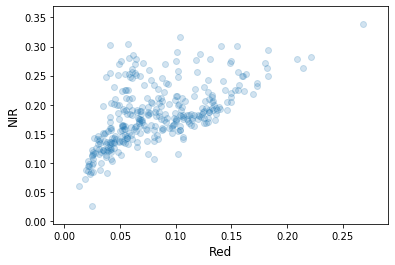

In [0]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat image.
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# Select Red and NIR bands, scale them, and sample 500 points.
samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()